## Setup

In [ ]:
!pip install -qq -U tensorflow-addons

In [ ]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers

import os

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

In [ ]:
from google.colab import drive

# Importing the dataset (stored in Google Drive)
drive.mount("/content/drive", force_remount=True)

# !ls "/content/drive/MyDrive/Cotton Dataset/data"

Mounted at /content/drive


## Prepare the data

In [ ]:
# NUM_CLASSES = 100
# INPUT_SHAPE = (32, 32, 3)

# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

# print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
# print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


# Download the dataset from GitHub
!rm -rf Cotton-Disease-Identification
!git clone https://github.com/GoelBiju/Cotton-Disease-Identification


Cloning into 'Cotton-Disease-Identification'...
remote: Enumerating objects: 1938, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 1938 (delta 3), reused 0 (delta 0), pack-reused 1927
Receiving objects: 100% (1938/1938), 1.56 GiB | 23.92 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Checking out files: 100% (3777/3777), done.


## Configure the hyperparameters

In [ ]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 32 # 256, 32

# AUGMENTATION
# IMAGE_SIZE = 72
IMAGE_SIZE = 256
# PATCH_SIZE = 6
PATCH_SIZE = 21
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
print(NUM_PATCHES)

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 10

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

144


In [ ]:
# NUM_CLASSES = 2
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Data directory
data_dir = "/content/Cotton-Disease-Identification/data"

# Load in the data in expected format (x_train, y_train), (x_test, y_test)
train_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(data_dir, 'train'),
  # validation_split=0.2,
  # subset="training",
  seed=42,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)


val_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(data_dir, 'val'),
  # validation_split=0.2,
  # subset="validation",
  seed=42,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)


test_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(data_dir, 'test'),
  seed=42,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

# for x, y in train_ds.take(1):
#   print(x.shape, y.shape)

x_train, y_train = np.concatenate(list(train_ds.map(lambda x, y: x))), np.concatenate(list(train_ds.map(lambda x, y: y)))
x_val, y_val = np.concatenate(list(val_ds.map(lambda x, y: x))), np.concatenate(list(val_ds.map(lambda x, y: y)))

Cause: could not parse the source code of <function <lambda> at 0x7fb839f25710>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: x)

Match 1:
(lambda x, y: y)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb839f25710>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: x)

Match 1:
(lambda x, y: y)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb83a395950>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: x)

Match 1:
(lambda x, y: y)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb83a395950>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: x)

Match 1:
(lambda x, y: y)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb83a395290>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: x)

Match 1:
(lambda x, y: y)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb83a395290>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
(lambda x, y: x)

Match 1:
(lambda x, y: y)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Data augmentation


In [ ]:
# 1. Apply rescaling on the data...
# 2. Output the mean and std calculated from dataset...
# 2. Use our custom mean and standard deviation...

# normalisation_layer = tf.keras.layers.Rescaling(1./255)

# train_ds = train_ds.map(lambda x, y: (normalisation_layer(x), y))
# val_ds = val_ds.map(lambda x, y: (normalisation_layer(x), y))

# resize_and_rescale = tf.keras.Sequential([
#   layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#   layers.Rescaling(1./255)
# ])

# mean = (0.4871, 0.5598, 0.3781)
# std = (0.1980, 0.1862, 0.1908)

data_augmentation = keras.Sequential(
    [
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.Rescaling(1./255),

        # layers.RandomFlip("horizontal"),
        # layers.RandomRotation(factor=0.02),
        # layers.RandomZoom(height_factor=0.2, width_factor=0.2),
     
        layers.Normalization(mean=[0.4871, 0.5598, 0.3781], 
                             variance=[np.square(0.1980), np.square(0.1862), np.square(0.1908)]),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[1].adapt(x_train)
# print(data_augmentation.layers[1])

# data_augmentation.layers[1].adapt(x_train)


# normalisation_layer = tf.keras.layers.Rescaling(1./255)

# train_ds = train_ds.map(lambda x, y: (normalisation_layer(x), y))
# val_ds = val_ds.map(lambda x, y: (normalisation_layer(x), y))


## Implement Shifted Patch Tokenization

In a ViT pipeline, the input images are divided into patches that are
then linearly projected into tokens. Shifted patch tokenization (STP)
is introduced to combat the low receptive field of ViTs. The steps
for Shifted Patch Tokenization are as follows:

- Start with an image.
- Shift the image in diagonal directions.
- Concat the diagonally shifted images with the original image.
- Extract patches of the concatenated images.
- Flatten the spatial dimension of all patches.
- Layer normalize the flattened patches and then project it.

| ![Shifted Patch Toekenization](https://i.imgur.com/bUnHxd0.png) |
| :--: |
| Shifted Patch Tokenization [Source](https://arxiv.org/abs/2112.13492v1) |

In [ ]:

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)


### Visualize the patches

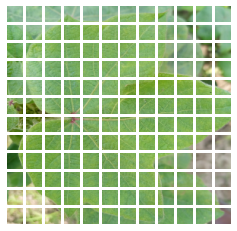

ORIGINAL


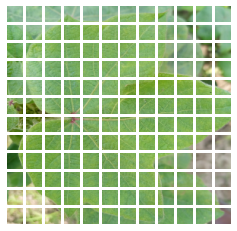

LEFT-UP


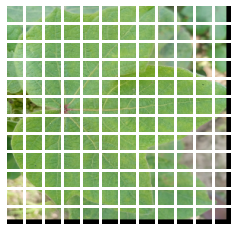

LEFT-DOWN


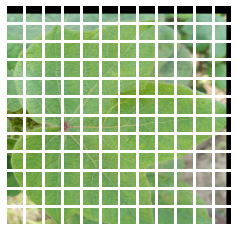

RIGHT-UP


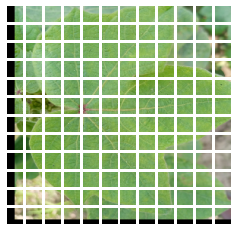

RIGHT-DOWN


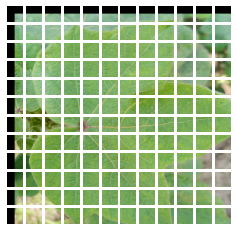

In [ ]:
# Get a random image from the training dataset
# and resize the image
image = x_train[np.random.choice(range(x_train.shape[0]))]

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

## Implement the patch encoding layer

This layer accepts projected patches and then adds positional
information to them.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


## Implement Locality Self Attention

The regular attention equation is stated below.

| ![Equation of attention](https://miro.medium.com/max/396/1*P9sV1xXM10t943bXy_G9yg.png) |
| :--: |
| [Source](https://towardsdatascience.com/attention-is-all-you-need-discovering-the-transformer-paper-73e5ff5e0634) |

The attention module takes a query, key, and value. First, we compute the
similarity between the query and key via a dot product. Then, the result
is scaled by the square root of the key dimension. The scaling prevents
the softmax function from having an overly small gradient. Softmax is then
applied to the scaled dot product to produce the attention weights.
The value is then modulated via the attention weights.

In self-attention, query, key and value come from the same input.
The dot product would result in large self-token relations rather than
inter-token relations. This also means that the softmax gives higher
probabilities to self-token relations than the inter-token relations.
To combat this, the authors propose masking the diagonal of the dot product.
This way, we force the attention module to pay more attention to the
inter-token relations.

The scaling factor is a constant in the regular attention module.
This acts like a temperature term that can modulate the softmax function.
The authors suggest a learnable temperature term instead of a constant.

| ![Implementation of LSA](https://i.imgur.com/GTV99pk.png) |
| :--: |
| Locality Self Attention [Source](https://arxiv.org/abs/2112.13492v1) |

The above two pointers make the Locality Self Attention. We have subclassed the
[`layers.MultiHeadAttention`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
and implemented the trainable temperature. The attention mask is built
at a later stage.

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


## Implement the MLP

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

## Build the ViT

In [ ]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented) # augmented, inputs
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)

    # Classify outputs.
    # logits = layers.Dense(NUM_CLASSES)(features)
    logits = layers.Dense(1, activation="sigmoid")(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model



## Compile, train, and evaluate the mode

In [ ]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    # total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    total_steps = int((1318 / BATCH_SIZE) * EPOCHS)
    print(total_steps)

    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        # loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        loss="binary_crossentropy",
        # loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            # keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            # keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            "accuracy"
        ],
    )

    history = model.fit(
        # x=x_train,
        # y=y_train,
        train_ds,
        validation_data=val_ds,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        # validation_split=0.1,
        # validation_data=(x_test, y_test),
        validation_steps=10,
    )

    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
    # accuracy, loss = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test loss: {loss}")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


# Clear the backend for any older models before initialising
tf.keras.backend.clear_session()

# Run experiments with the vanilla ViT
# vit = create_vit_classifier(vanilla=True)
# vit.summary()

# history = run_experiment(vit)

# Run experiments with the Shifted Patch Tokenization and
# Locality Self Attention modified ViT
vit_sl = create_vit_classifier(vanilla=False)
history = run_experiment(vit_sl)



411
Epoch 1/10
42/42 [==============================] - 59s 366ms/step - loss: 1.6034 - accuracy: 0.7595 - val_loss: 0.7462 - val_accuracy: 0.7594
Epoch 2/10
42/42 [==============================] - 16s 328ms/step - loss: 0.6454 - accuracy: 0.8331 - val_loss: 0.3736 - val_accuracy: 0.8562
Epoch 3/10
42/42 [==============================] - 16s 327ms/step - loss: 0.3120 - accuracy: 0.8923 - val_loss: 0.4204 - val_accuracy: 0.8469
Epoch 4/10
42/42 [==============================] - 16s 327ms/step - loss: 0.1685 - accuracy: 0.9423 - val_loss: 0.3944 - val_accuracy: 0.8719
Epoch 5/10
42/42 [==============================] - 16s 329ms/step - loss: 0.1209 - accuracy: 0.9583 - val_loss: 0.5680 - val_accuracy: 0.8156
Epoch 6/10
42/42 [==============================] - 16s 325ms/step - loss: 0.1350 - accuracy: 0.9537 - val_loss: 0.4478 - val_accuracy: 0.8500
Epoch 7/10
42/42 [==============================] - 16s 328ms/step - loss: 0.1139 - accuracy: 0.9643 - val_loss: 0.3917 - val_accuracy: 0.

In [ ]:
!rm -rf /content/models

In [ ]:
# Model save variables
save_dir = "/content/models/"
model_name = 'proj518_vit_sl-2'

print("Saving as: ", save_dir + model_name)
vit_sl.save(os.path.join(save_dir, model_name))

Saving as:  /content/models/proj518_vit_sl-2


In [ ]:
# You can also evaluate or predict on a dataset.
print(test_ds.class_names)

# print("Evaluate")
result = vit_sl.evaluate(test_ds)

['healthy', 'leaf_curl']
6/6 [==============================] - 2s 44ms/step - loss: 0.6309 - accuracy: 0.8010


In [ ]:
import cv2

# # Predictions on test datasets
test_dir = "/content/testing/healthy"


# # Get image path
# image_path = os.path.join(test_dir, "leaf_curl", "leaf_curl_100.jpg")
# print(image_path)

# # Open the image
# img = cv2.imread(image_path)

# # Resize the image
# resize = tf.image.resize(img, (256, 256))

# # NOTE: We do resizing anyway in the model input layers
# # yhat = vit_sl.predict(np.expand_dims(resize / 255, 0))

# prediction = vit_sl.predict(np.expand_dims(resize, 0))
# print(prediction)


# Loop through all the leaf curl images
correct = 0
files = os.listdir(test_dir)
total = len(files)
print(total)

for image_name in files:
  print(image_name)

  # Get image path
  image_path = os.path.join(test_dir, image_name)
  print(image_path)

  # Open the image
  img = cv2.imread(image_path)

  # Resize the image
  resize = tf.image.resize(img, (256, 256))

  yhat = vit_sl.predict(np.expand_dims(resize, 0))
  print(yhat)

  if yhat > 0.5: 
      print(f'Predicted class is leaf curl')
  else:
      print(f'Predicted class is healthy')
      correct += 1


954
healthy_716.jpg
/content/testing/healthy/healthy_716.jpg
[[4.809746e-05]]
Predicted class is healthy
healthy_277.jpg
/content/testing/healthy/healthy_277.jpg
[[0.14566968]]
Predicted class is healthy
healthy_244.jpg
/content/testing/healthy/healthy_244.jpg
[[0.0005512]]
Predicted class is healthy
healthy_836.jpg
/content/testing/healthy/healthy_836.jpg
[[1.6197907e-06]]
Predicted class is healthy
healthy_162.jpg
/content/testing/healthy/healthy_162.jpg
[[0.00570746]]
Predicted class is healthy
healthy_452.jpg
/content/testing/healthy/healthy_452.jpg
[[3.440733e-06]]
Predicted class is healthy
healthy_430.jpg
/content/testing/healthy/healthy_430.jpg
[[0.07550014]]
Predicted class is healthy
healthy_9.jpg
/content/testing/healthy/healthy_9.jpg
[[0.01287309]]
Predicted class is healthy
healthy_800.jpg
/content/testing/healthy/healthy_800.jpg
[[0.00163532]]
Predicted class is healthy
healthy_455.jpg
/content/testing/healthy/healthy_455.jpg
[[0.00012398]]
Predicted class is healthy
heal

In [ ]:
print(correct)

766


In [ ]:
full_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/testing",
  seed=42,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

res = vit_sl.evaluate(full_ds)

Found 1078 files belonging to 2 classes.
34/34 [==============================] - 13s 300ms/step - loss: 0.1678 - accuracy: 0.9527


In [ ]:
# Plot accuracy
hist = history

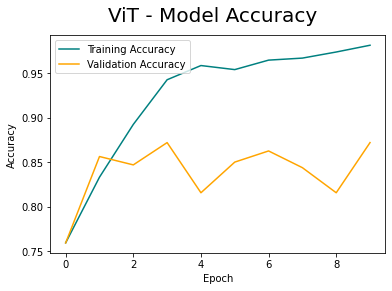

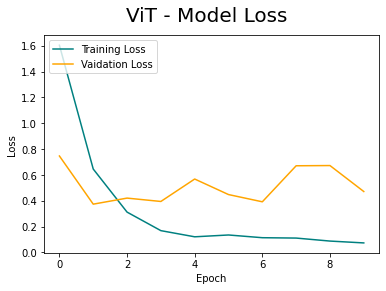

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
fig.suptitle('ViT - Model Accuracy', fontsize=20)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()


# Plot loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Training Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Vaidation Loss')
fig.suptitle('ViT - Model Loss', fontsize=20)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()